# ACTIVIDAD 3: K-Means,  DBSCAN y  PCA
---
 
Autor: Jesus Balbuena Palma
Fecha: 16/10/2025

**Objetivo:**

Comprender, implementar y analizar los algoritmos Máquinas de Vectores de Soporte (SVM)
y k-Vecinos más Cercanos (K-NN) en problemas de clasificación, evaluando cómo los
hiperparámetros y el escalado de características afectan el margen, los vectores de soporte,
las fronteras de decisión, el sobreajuste y el desempeño cuantitativo del modelo.


## ACTIVIDAD 1: K-Means

In [1]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.datasets import load_digits, make_blobs, load_iris
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics

# Configuración de estilo para las gráficas
plt.style.use('default')
sns.set_palette("husl")



--- Carga del Dataset de Dígitos ---
Número de dígitos únicos: 10
Número de muestras: 1797
Número de características: 64


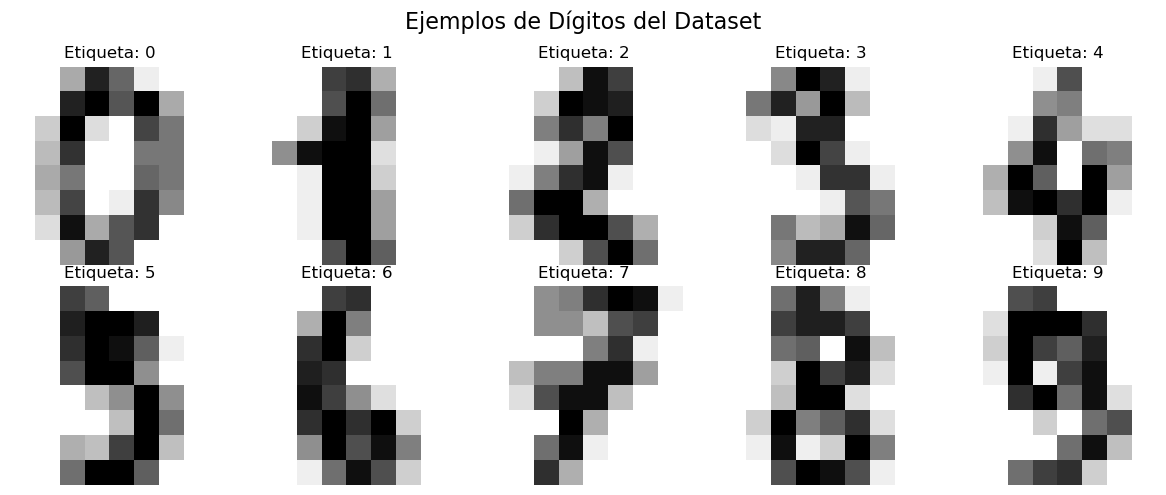

In [2]:
# ----------------------------------------------------------------------------
# 1.A. CARGA Y EXPLORACIÓN DEL DATASET DE DÍGITOS
# ----------------------------------------------------------------------------

print("\n--- Carga del Dataset de Dígitos ---")

# Cargar el dataset de dígitos
data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"Número de dígitos únicos: {n_digits}")
print(f"Número de muestras: {n_samples}")
print(f"Número de características: {n_features}")

# Visualización de algunos dígitos del dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Ejemplos de Dígitos del Dataset', fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i].reshape(8, 8), cmap='binary')
    ax.set_title(f'Etiqueta: {labels[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# ----------------------------------------------------------------------------
# 1.B. FUNCIÓN DE EVALUACIÓN DE K-MEANS
# ----------------------------------------------------------------------------

def bench_k_means(kmeans, name, data, labels):
    """
    Función para evaluar el rendimiento de KMeans con diferentes inicializaciones.
    
    Parámetros:
    -----------
    kmeans : KMeans instance
        Instancia de KMeans con inicialización configurada
    name : str
        Nombre de la estrategia de inicialización
    data : ndarray
        Datos a agrupar (n_samples, n_features)
    labels : ndarray
        Etiquetas verdaderas para evaluar el clustering
    
    Retorna:
    --------
    results : list
        Lista con métricas de evaluación
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Métricas de clustering que requieren etiquetas verdaderas
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # Coeficiente de silueta
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Mostrar resultados
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    
    return results


In [4]:
# ----------------------------------------------------------------------------
# 1.C. EVALUACIÓN DE K-MEANS CON DIFERENTES INICIALIZACIONES
# ----------------------------------------------------------------------------

print("\n--- Evaluación de K-Means con n_clusters = {} ---".format(n_digits))
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

# K-Means con inicialización k-means++
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

# K-Means con inicialización aleatoria
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

# K-Means con inicialización basada en PCA
pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1, random_state=0)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)


--- Evaluación de K-Means con n_clusters = 10 ---
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.130s	69545	0.598	0.645	0.621	0.469	0.617	0.160
random   	0.022s	69735	0.681	0.723	0.701	0.574	0.698	0.176
PCA-based	0.009s	69513	0.600	0.647	0.622	0.468	0.618	0.145


['PCA-based',
 0.008926868438720703,
 69513.44076564349,
 0.5995200438256008,
 0.6467562369499692,
 0.6222429705224426,
 0.46817714209887135,
 0.6182708093169968,
 0.1447923384349681]


--- Visualización de K-Means con PCA ---


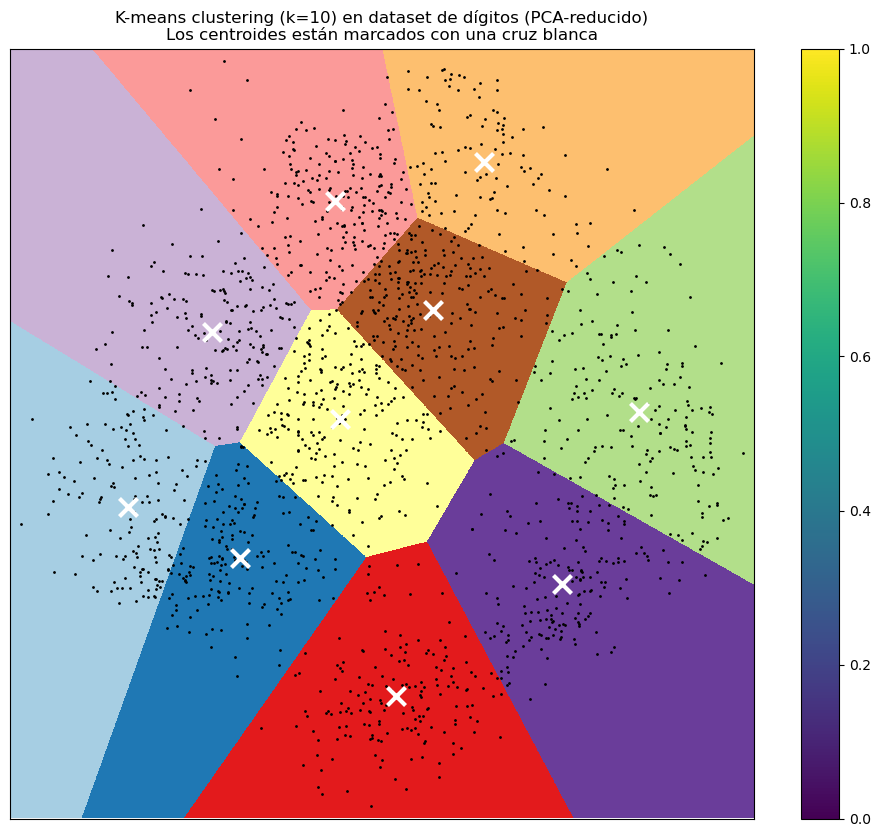

In [5]:
# ----------------------------------------------------------------------------
# 1.D. VISUALIZACIÓN DE K-MEANS CON REDUCCIÓN PCA
# ----------------------------------------------------------------------------

print("\n--- Visualización de K-Means con PCA ---")

# Reducir los datos a 2 componentes principales
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
kmeans.fit(reduced_data)

# Crear malla para visualizar regiones de decisión
h = 0.02  # Tamaño de paso de la malla
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtener predicciones para cada punto de la malla
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualización
plt.figure(figsize=(12, 10))
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

# Marcar los centroides
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    f"K-means clustering (k={n_digits}) en dataset de dígitos (PCA-reducido)\n"
    "Los centroides están marcados con una cruz blanca"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.colorbar()
plt.show()



--- Visualización de Centroides Reconstruidos ---


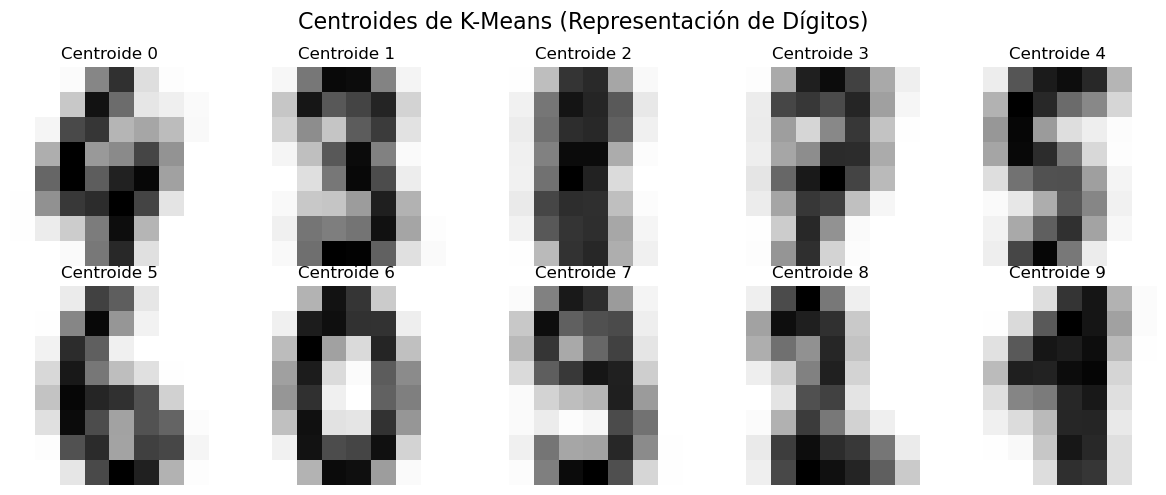

In [6]:
# ----------------------------------------------------------------------------
# 1.E. VISUALIZACIÓN DE CENTROIDES RECONSTRUIDOS
# ----------------------------------------------------------------------------

print("\n--- Visualización de Centroides Reconstruidos ---")

# Entrenar K-Means en datos originales (no reducidos)
kmeans_full = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
kmeans_full.fit(data)

# Visualizar los centroides como imágenes de dígitos
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Centroides de K-Means (Representación de Dígitos)', fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(kmeans_full.cluster_centers_[i].reshape(8, 8), cmap='binary')
    ax.set_title(f'Centroide {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()



--- K-Means con n_clusters = 8 ---
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k++_n4   	0.024s	75208	0.564	0.669	0.612	0.465	0.609	0.138
k++_n10  	0.043s	75181	0.530	0.646	0.582	0.412	0.579	0.142
k++_n20  	0.084s	74983	0.610	0.740	0.669	0.487	0.666	0.140
__________________________________________________________________________________


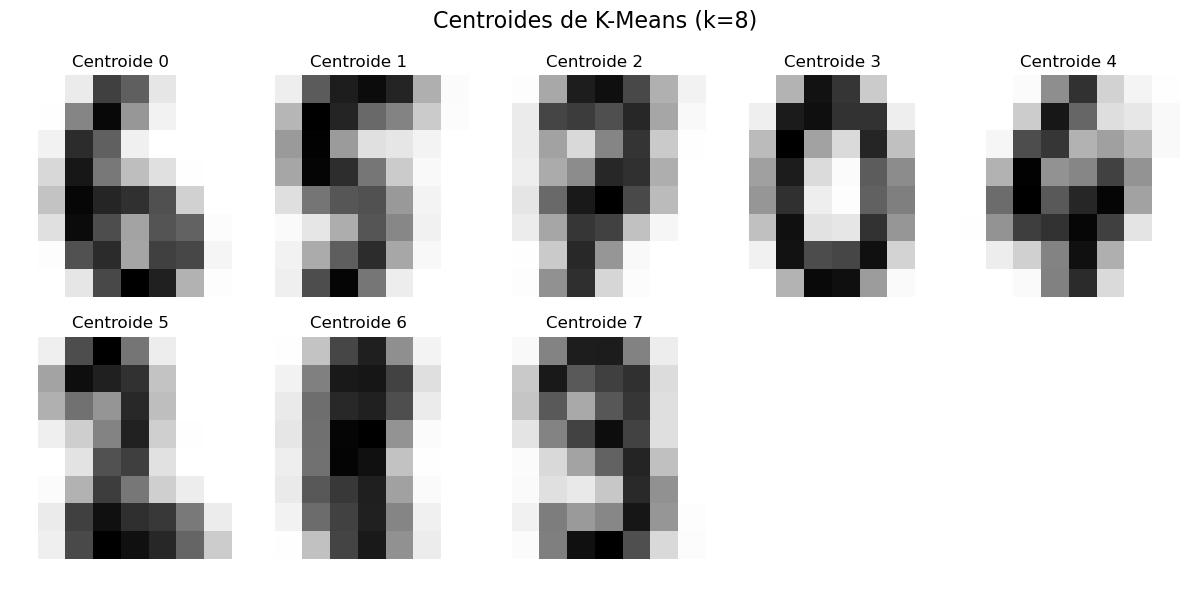


--- K-Means con n_clusters = 10 ---
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k++_n4   	0.026s	69545	0.598	0.645	0.621	0.469	0.617	0.156
k++_n10  	0.062s	69405	0.603	0.651	0.626	0.468	0.622	0.170
k++_n20  	0.111s	69405	0.603	0.651	0.626	0.468	0.622	0.172
__________________________________________________________________________________


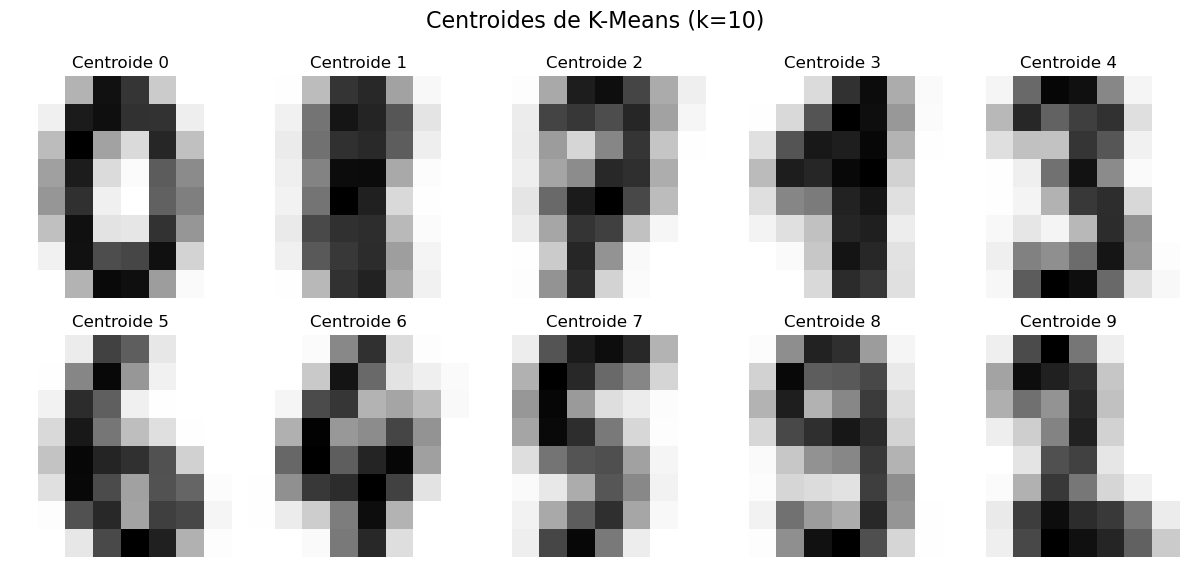


--- K-Means con n_clusters = 12 ---
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k++_n4   	0.035s	66114	0.708	0.698	0.703	0.575	0.699	0.180
k++_n10  	0.076s	65116	0.678	0.691	0.684	0.547	0.680	0.173
k++_n20  	0.166s	65116	0.678	0.691	0.684	0.547	0.680	0.155
__________________________________________________________________________________


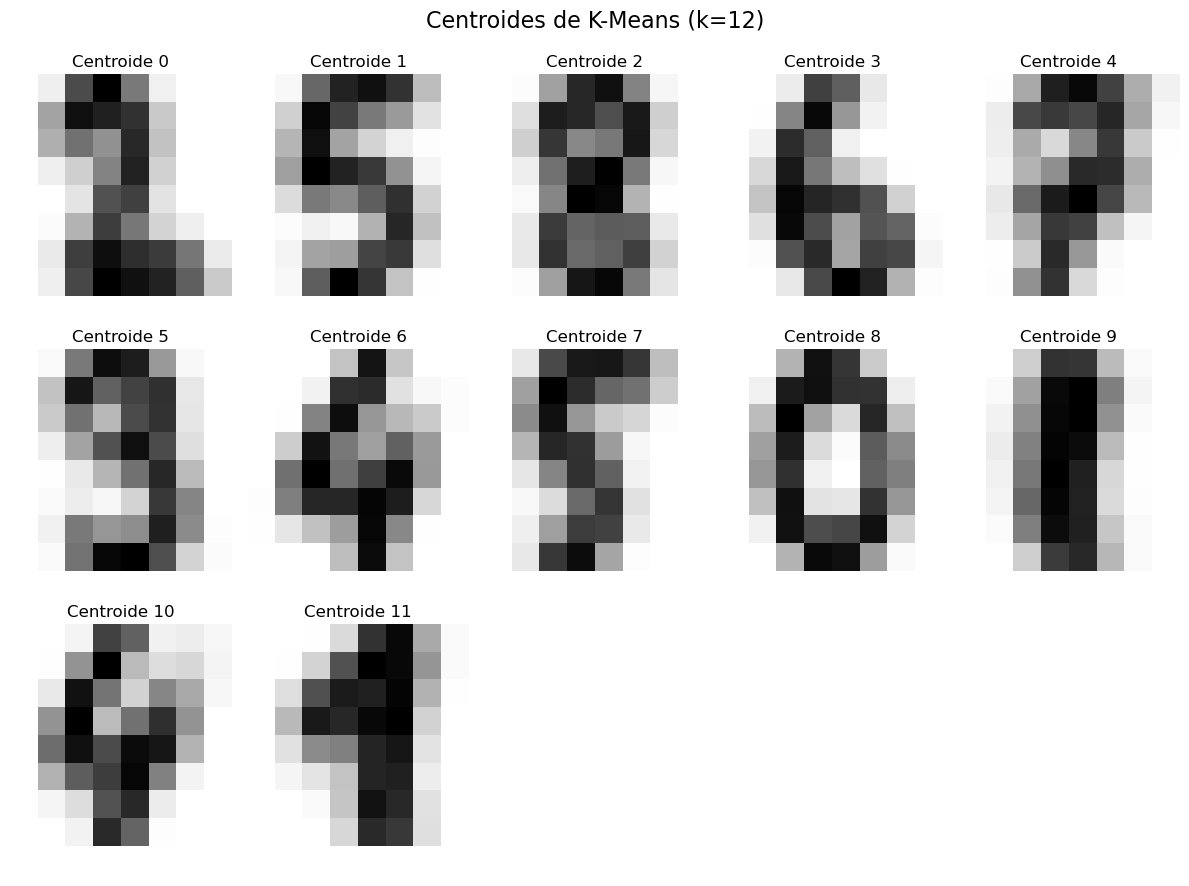

In [7]:
# ----------------------------------------------------------------------------
# 1.F. MODIFICACIONES: DIFERENTES VALORES DE K Y N_INIT
# ----------------------------------------------------------------------------

# Probar con diferentes números de clusters
n_clusters_list = [8, 10, 12]
n_init_list = [4, 10, 20]

for n_clusters_test in n_clusters_list:
    print(f"\n--- K-Means con n_clusters = {n_clusters_test} ---")
    print(82 * "_")
    print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
    
    for n_init_test in n_init_list:
        kmeans_test = KMeans(
            init="k-means++", 
            n_clusters=n_clusters_test, 
            n_init=n_init_test, 
            random_state=0
        )
        bench_k_means(
            kmeans=kmeans_test, 
            name=f"k++_n{n_init_test}", 
            data=data, 
            labels=labels
        )
    
    print(82 * "_")
    
    # Visualizar centroides para este valor de k
    kmeans_viz = KMeans(
        init="k-means++", 
        n_clusters=n_clusters_test, 
        n_init=10, 
        random_state=0
    )
    kmeans_viz.fit(data)
    
    # Determinar disposición de subplots
    n_rows = (n_clusters_test + 4) // 5
    n_cols = min(5, n_clusters_test)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
    fig.suptitle(f'Centroides de K-Means (k={n_clusters_test})', fontsize=16)
    
    if n_clusters_test <= 5:
        axes_flat = [axes] if n_clusters_test == 1 else axes
    else:
        axes_flat = axes.flat
    
    for i in range(n_clusters_test):
        ax = axes_flat[i]
        ax.imshow(kmeans_viz.cluster_centers_[i].reshape(8, 8), cmap='binary')
        ax.set_title(f'Centroide {i}')
        ax.axis('off')
    
    # Ocultar ejes sobrantes
    for j in range(n_clusters_test, len(axes_flat)):
        axes_flat[j].axis('off')
    
    plt.tight_layout()
    plt.show()

### Conclusiones K-Means

En el experimento con el dataset de dígitos, K-Means logró agrupar de forma razonable las diferentes clases cuando se fijó un número de clústers coherente con el problema (k cercano al número de dígitos distintos). Al variar k entre diferentes valores se observó que:

- Con valores de k menores, varios dígitos distintos terminan en el mismo clúster, lo que reduce la homogeneidad y hace más difícil interpretar los centroides.
- Con valores de k mayores, la inercia disminuye porque los clústers son más pequeños, pero aparecen grupos poco representativos y menos útiles desde el punto de vista práctico.

En cuanto a la inicialización, k-means++ mostró un mejor equilibrio entre inercia y métricas de calidad frente a la inicialización completamente aleatoria, mientras que la inicialización basada en PCA ofreció un compromiso intermedio. Esto confirma que K-Means es sensible tanto a la elección de k como a la forma en que se inicializan los centroides.

En general, K-Means funciona bien cuando los clústers son aproximadamente esféricos y de densidad similar, pero requiere una exploración sistemática de k y de la inicialización para obtener resultados estables y bien interpretables.


## ACTIVIDAD 2: DBSCAN


--- Generación de Dataset Sintético ---
Número de muestras: 750
Número de características: 2
Número de clusters verdaderos: 3


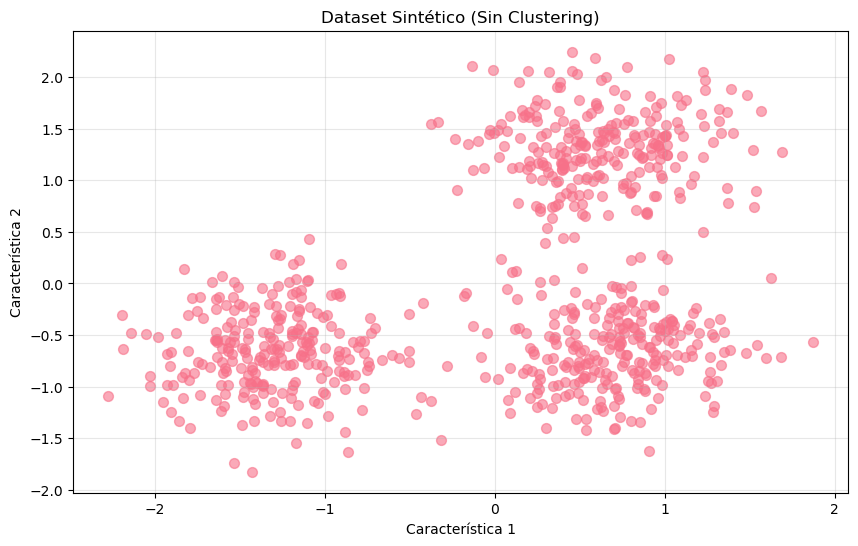

In [8]:
# ----------------------------------------------------------------------------
# 2.A. GENERACIÓN DE DATASET SINTÉTICO
# ----------------------------------------------------------------------------

print("\n--- Generación de Dataset Sintético ---")

# Crear dataset con blobs (grupos esféricos)
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, 
    centers=centers, 
    cluster_std=0.4, 
    random_state=0
)

# Estandarizar los datos
X = StandardScaler().fit_transform(X)

print(f"Número de muestras: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")
print(f"Número de clusters verdaderos: {len(centers)}")

# Visualización del dataset sin clustering
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6)
plt.title('Dataset Sintético (Sin Clustering)')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.grid(True, alpha=0.3)
plt.show()



In [9]:
# ----------------------------------------------------------------------------
# 2.B. APLICACIÓN DE DBSCAN
# ----------------------------------------------------------------------------

print("\n--- Aplicación de DBSCAN (eps=0.3, min_samples=10) ---")

# Aplicar DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels_dbscan = db.labels_

# Calcular estadísticas
n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)

print(f"Número estimado de clusters: {n_clusters_}")
print(f"Número estimado de puntos de ruido: {n_noise_}")
print(f"Homogeneidad: {metrics.homogeneity_score(labels_true, labels_dbscan):.3f}")
print(f"Completitud: {metrics.completeness_score(labels_true, labels_dbscan):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels_dbscan):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels_dbscan):.3f}")
print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(labels_true, labels_dbscan):.3f}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels_dbscan):.3f}")


--- Aplicación de DBSCAN (eps=0.3, min_samples=10) ---
Número estimado de clusters: 3
Número estimado de puntos de ruido: 18
Homogeneidad: 0.953
Completitud: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626



--- Visualización de Clusters DBSCAN ---


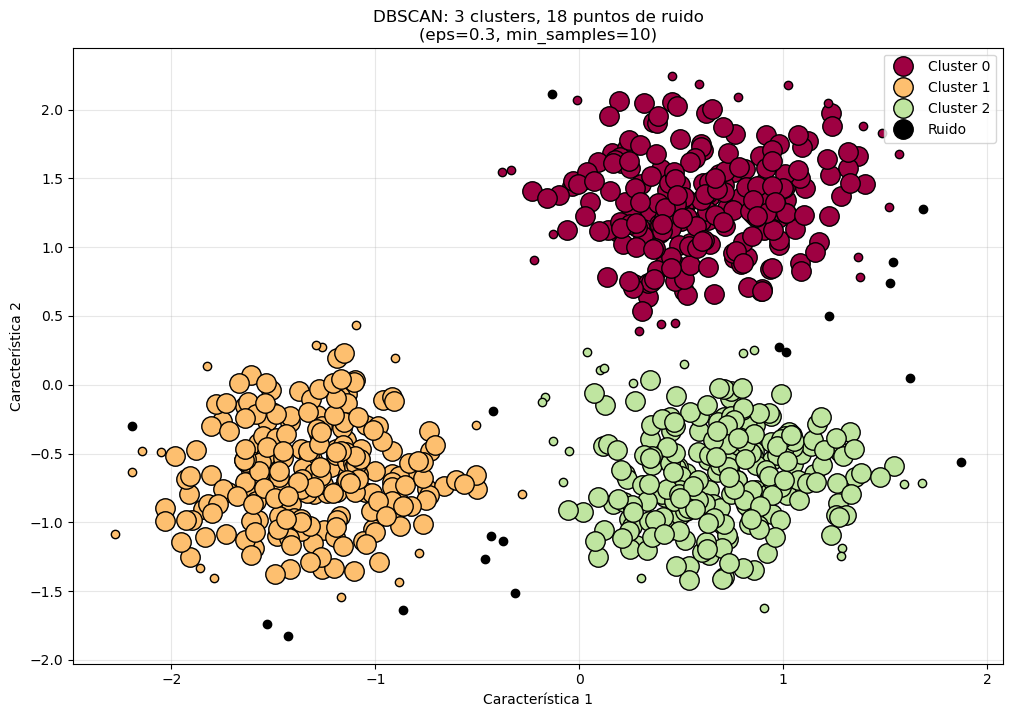

In [10]:
# ----------------------------------------------------------------------------
# 2.C. VISUALIZACIÓN DE DBSCAN
# ----------------------------------------------------------------------------

print("\n--- Visualización de Clusters DBSCAN ---")

# Preparar visualización
unique_labels = set(labels_dbscan)
core_samples_mask = np.zeros_like(labels_dbscan, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 8))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro para puntos de ruido
        col = [0, 0, 0, 1]
    
    class_member_mask = labels_dbscan == k
    
    # Puntos núcleo
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
        label=f'Cluster {k}' if k != -1 else 'Ruido'
    )
    
    # Puntos de borde
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"DBSCAN: {n_clusters_} clusters, {n_noise_} puntos de ruido\n(eps=0.3, min_samples=10)")
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



MODIFICACIONES DBSCAN: Diferentes valores de eps y min_samples


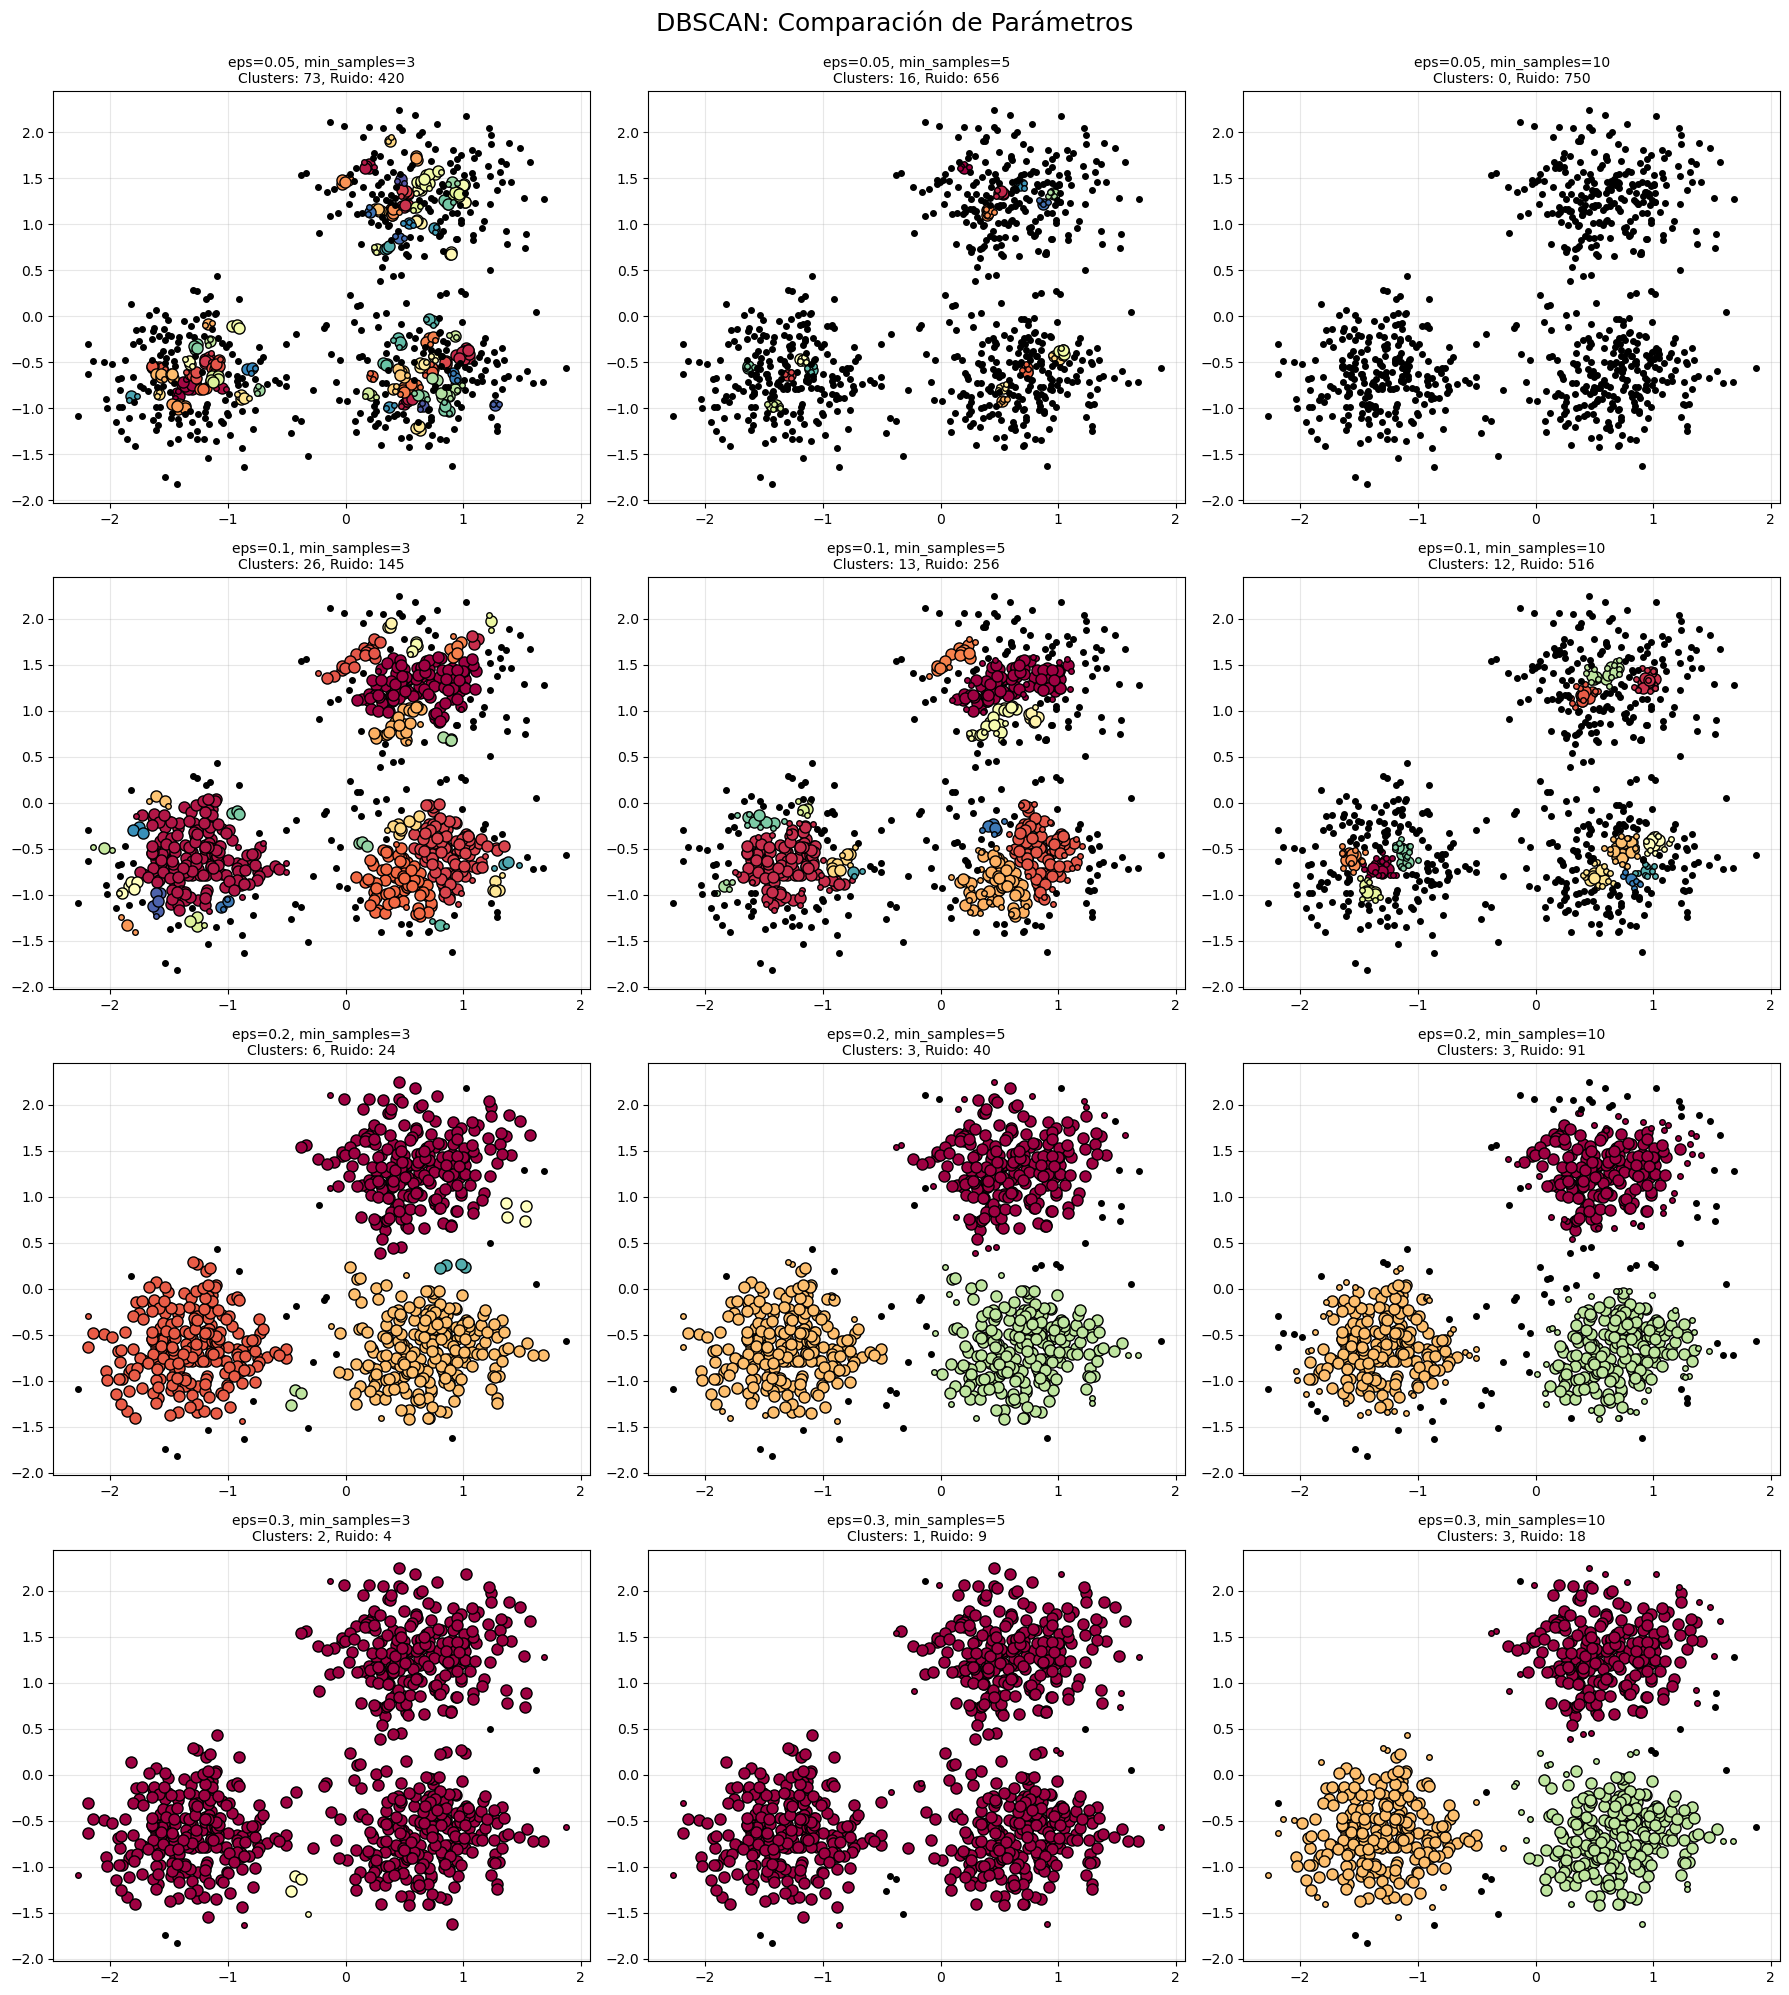


--- Tabla Comparativa de Resultados DBSCAN ---
 eps  min_samples  n_clusters  n_noise  homogeneity  completeness  v_measure          ari  silhouette
0.05            3          73      420     0.440340      0.190976   0.266409 7.721693e-03   -0.235868
0.05            5          16      656     0.125430      0.190750   0.151343 1.822548e-03   -0.618687
0.05           10           0      750     0.000000      1.000000   0.000000 0.000000e+00   -1.000000
0.10            3          26      145     0.810303      0.396938   0.532851 3.928718e-01   -0.122569
0.10            5          13      256     0.660602      0.374795   0.478252 2.589919e-01   -0.128400
0.10           10          12      516     0.312781      0.248933   0.277228 2.366856e-02   -0.365853
0.20            3           6       24     0.956494      0.820339   0.883200 9.254509e-01    0.287959
0.20            5           3       40     0.939402      0.826807   0.879516 9.140896e-01    0.600124
0.20           10           3     

In [11]:
# ----------------------------------------------------------------------------
# 2.D. MODIFICACIONES: DIFERENTES VALORES DE EPS Y MIN_SAMPLES
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("MODIFICACIONES DBSCAN: Diferentes valores de eps y min_samples")
print("="*80)

# Configuraciones a probar
eps_values = [0.05, 0.10, 0.20, 0.3]
min_samples_values = [3, 5, 10]

# Crear figura con múltiples subplots
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(18, 20))
fig.suptitle('DBSCAN: Comparación de Parámetros', fontsize=18, y=0.995)

resultados_dbscan = []

for i, eps_val in enumerate(eps_values):
    for j, min_samples_val in enumerate(min_samples_values):
        # Aplicar DBSCAN
        db_test = DBSCAN(eps=eps_val, min_samples=min_samples_val).fit(X)
        labels_test = db_test.labels_
        
        # Calcular métricas
        n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise_test = list(labels_test).count(-1)
        
        # Guardar resultados
        resultados_dbscan.append({
            'eps': eps_val,
            'min_samples': min_samples_val,
            'n_clusters': n_clusters_test,
            'n_noise': n_noise_test,
            'homogeneity': metrics.homogeneity_score(labels_true, labels_test),
            'completeness': metrics.completeness_score(labels_true, labels_test),
            'v_measure': metrics.v_measure_score(labels_true, labels_test),
            'ari': metrics.adjusted_rand_score(labels_true, labels_test),
            'silhouette': metrics.silhouette_score(X, labels_test) if n_clusters_test > 0 else -1
        })
        
        # Visualizar
        ax = axes[i, j]
        
        unique_labels_test = set(labels_test)
        core_samples_mask_test = np.zeros_like(labels_test, dtype=bool)
        core_samples_mask_test[db_test.core_sample_indices_] = True
        
        colors_test = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_test))]
        
        for k, col in zip(unique_labels_test, colors_test):
            if k == -1:
                col = [0, 0, 0, 1]
            
            class_member_mask_test = labels_test == k
            
            xy = X[class_member_mask_test & core_samples_mask_test]
            ax.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col),
                   markeredgecolor="k", markersize=8)
            
            xy = X[class_member_mask_test & ~core_samples_mask_test]
            ax.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col),
                   markeredgecolor="k", markersize=4)
        
        ax.set_title(f'eps={eps_val}, min_samples={min_samples_val}\n'
                    f'Clusters: {n_clusters_test}, Ruido: {n_noise_test}',
                    fontsize=10)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
print("\n--- Tabla Comparativa de Resultados DBSCAN ---")
df_dbscan = pd.DataFrame(resultados_dbscan)
print(df_dbscan.to_string(index=False))

### Conclusiones DBSCAN

Al modificar los valores de `eps` y `min_samples` se observó que DBSCAN es muy sensible a estos hiperparámetros:

- Con valores de `eps` demasiado pequeños, el algoritmo identifica muchos puntos como ruido y forma varios clústers fragmentados, incluso dentro de una misma estructura.
- Con valores de `eps` demasiado grandes, los clústers tienden a fusionarse y se pierde la separación entre grupos que visualmente son distintos.
- Al aumentar `min_samples`, se vuelve más estricta la condición para que un punto sea núcleo; como consecuencia, crece la cantidad de puntos etiquetados como ruido y disminuye el número de clústers detectados.

Estas variaciones muestran que DBSCAN es adecuado para detectar clústers de forma arbitraria y para identificar ruido sin necesidad de especificar el número de clústers K. Sin embargo, requiere un ajuste cuidadoso de `eps` y `min_samples` en función de la escala del problema y de la densidad de los datos. Cuando los parámetros se eligen de forma adecuada, DBSCAN separa bien regiones densas y marca claramente los puntos atípicos.


## ACTIVIDAD 3: PCA (ANÁLISIS DE COMPONENTES PRINCIPALES)

In [12]:
# ----------------------------------------------------------------------------
# 3.A. CARGA DEL DATASET IRIS
# ----------------------------------------------------------------------------

print("\n--- Carga del Dataset Iris ---")

# Cargar dataset Iris
iris = load_iris(as_frame=True)
print("Claves del dataset:", iris.keys())
print(f"\nDimensiones de los datos: {iris.data.shape}")
print(f"Características: {list(iris.feature_names)}")
print(f"Clases: {list(iris.target_names)}")

# Agregar columna de nombres de especies
iris.frame["species"] = iris.target_names[iris.target]

# Mostrar primeras filas
print("\nPrimeras filas del dataset:")
print(iris.frame.head())


--- Carga del Dataset Iris ---
Claves del dataset: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Dimensiones de los datos: (150, 4)
Características: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Clases: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]

Primeras filas del dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target species  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa  



--- Exploración Visual con Pairplot ---


<Figure size 1200x1000 with 0 Axes>

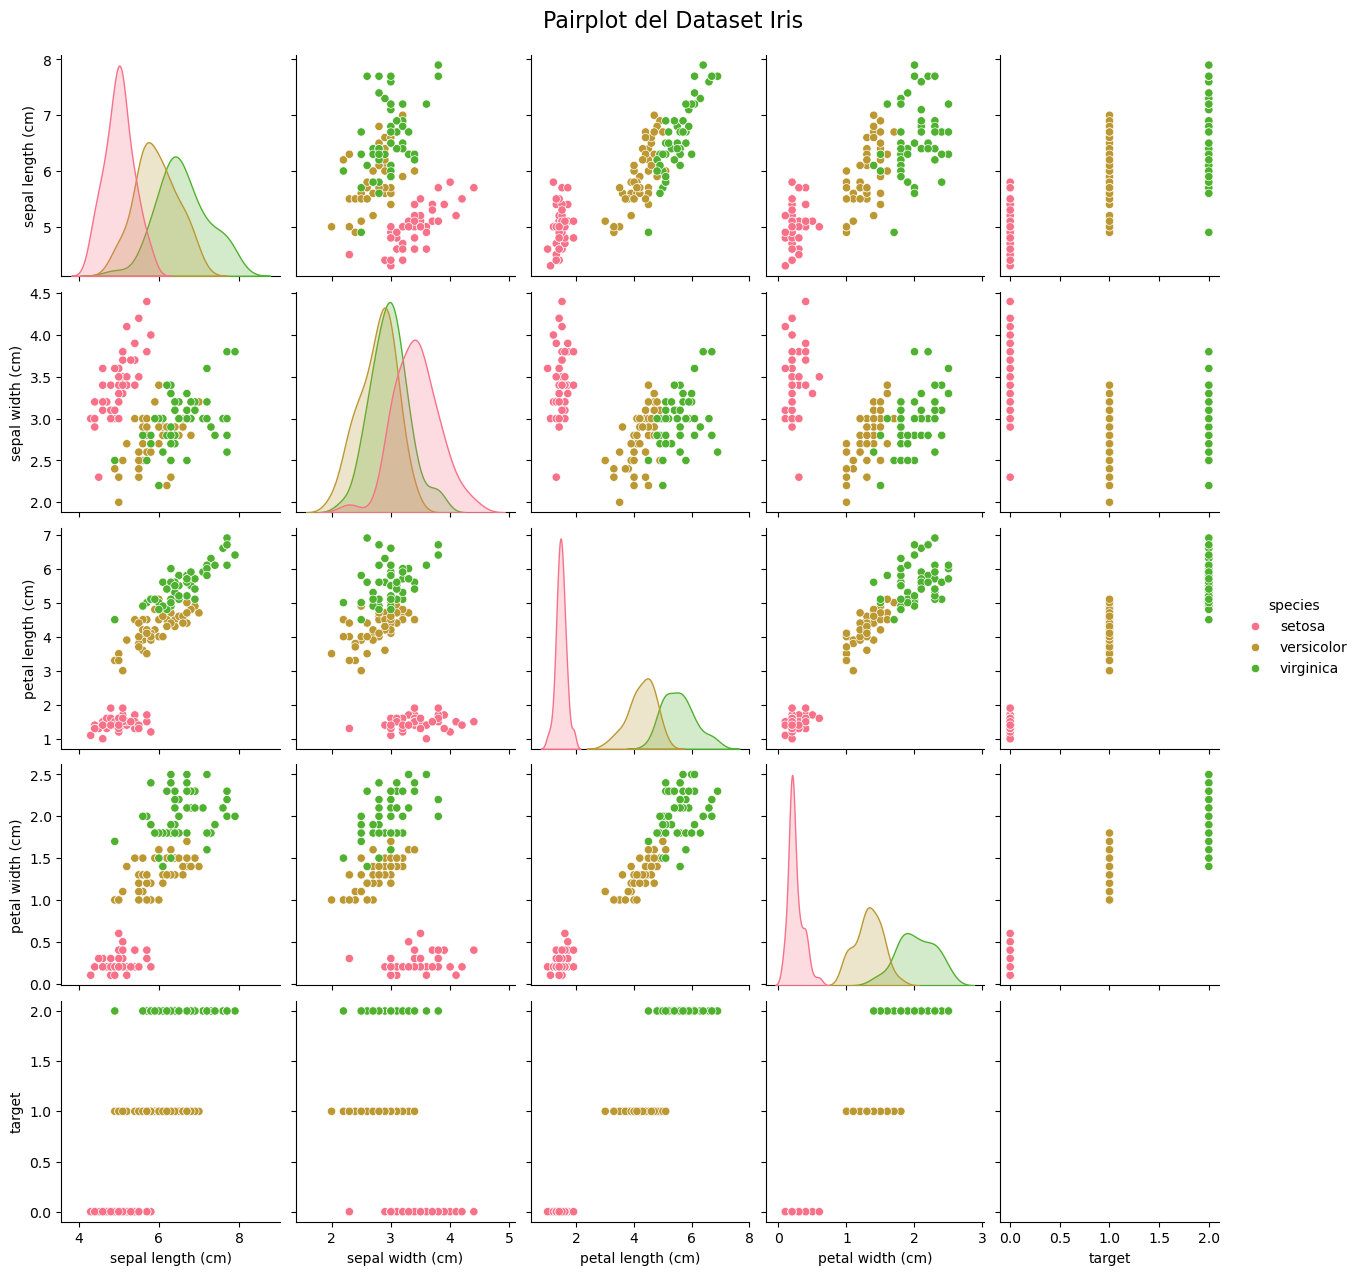

In [13]:
# ----------------------------------------------------------------------------
# 3.B. EXPLORACIÓN CON PAIRPLOT
# ----------------------------------------------------------------------------

print("\n--- Exploración Visual con Pairplot ---")

# Crear pairplot para visualizar relaciones entre características
plt.figure(figsize=(12, 10))
pairplot_fig = sns.pairplot(iris.frame, hue="species", diag_kind="kde", height=2.5)
pairplot_fig.fig.suptitle('Pairplot del Dataset Iris', y=1.02, fontsize=16)
plt.show()

In [14]:
# ----------------------------------------------------------------------------
# 3.C. ESTANDARIZACIÓN Y APLICACIÓN DE PCA
# ----------------------------------------------------------------------------

print("\n--- Aplicación de PCA (2 componentes) ---")

# Separar características y objetivo
X_iris = iris.data.values
y_iris = iris.target

# Estandarizar los datos
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Aplicar PCA con 2 componentes
pca_iris = PCA(n_components=2)
X_pca = pca_iris.fit_transform(X_iris_scaled)

print(f"Forma original de los datos: {X_iris.shape}")
print(f"Forma después de PCA: {X_pca.shape}")
print(f"\nVarianza explicada por cada componente:")
print(f"  PC1: {pca_iris.explained_variance_ratio_[0]:.4f} ({pca_iris.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca_iris.explained_variance_ratio_[1]:.4f} ({pca_iris.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total: {pca_iris.explained_variance_ratio_.sum():.4f} ({pca_iris.explained_variance_ratio_.sum()*100:.2f}%)")




--- Aplicación de PCA (2 componentes) ---
Forma original de los datos: (150, 4)
Forma después de PCA: (150, 2)

Varianza explicada por cada componente:
  PC1: 0.7296 (72.96%)
  PC2: 0.2285 (22.85%)
  Total: 0.9581 (95.81%)



--- Visualización PCA en 2D ---


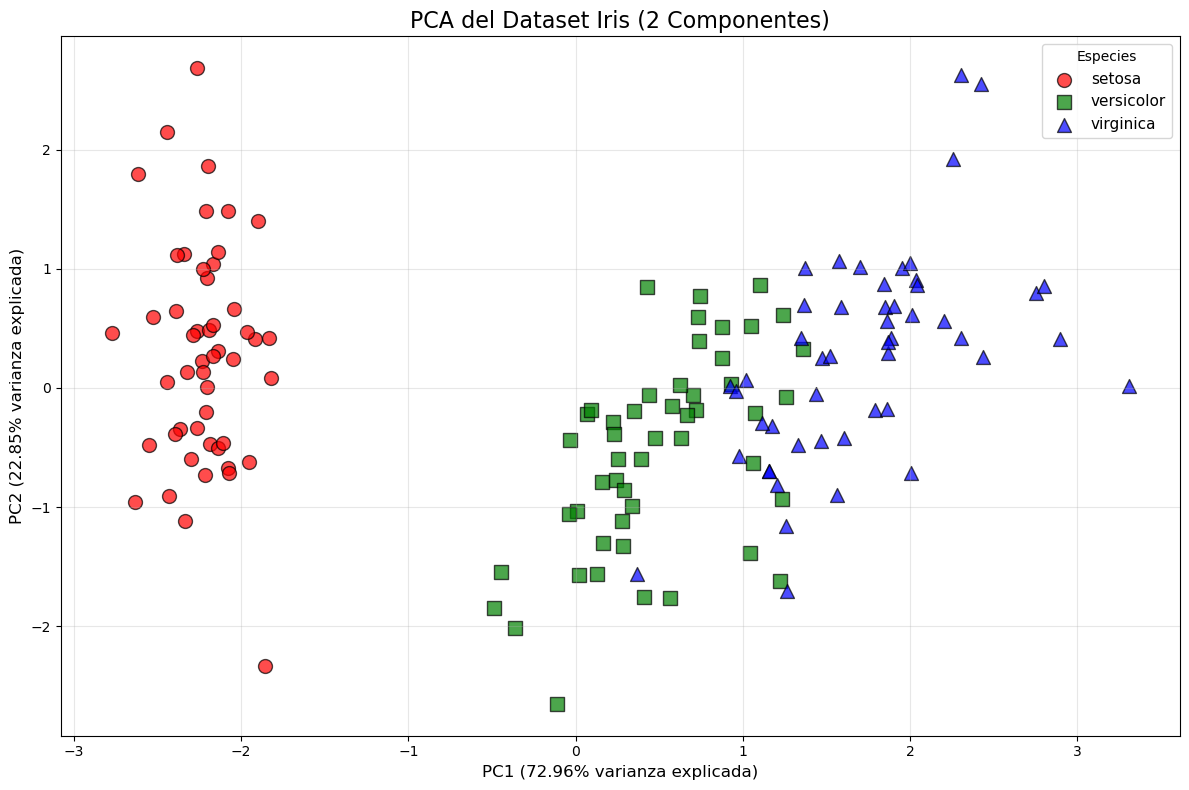

In [15]:

# ----------------------------------------------------------------------------
# 3.D. VISUALIZACIÓN PCA 2D
# ----------------------------------------------------------------------------

print("\n--- Visualización PCA en 2D ---")

# Crear DataFrame para facilitar la visualización
pca_df = pd.DataFrame(
    data=X_pca,
    columns=['PC1', 'PC2']
)
pca_df['species'] = iris.target_names[y_iris]

# Visualización con scatter plot
plt.figure(figsize=(12, 8))
colors_iris = ['red', 'green', 'blue']
markers = ['o', 's', '^']

for i, species in enumerate(iris.target_names):
    mask = pca_df['species'] == species
    plt.scatter(
        pca_df.loc[mask, 'PC1'],
        pca_df.loc[mask, 'PC2'],
        c=colors_iris[i],
        marker=markers[i],
        label=species,
        s=100,
        alpha=0.7,
        edgecolors='black'
    )

plt.xlabel(f'PC1 ({pca_iris.explained_variance_ratio_[0]*100:.2f}% varianza explicada)', fontsize=12)
plt.ylabel(f'PC2 ({pca_iris.explained_variance_ratio_[1]*100:.2f}% varianza explicada)', fontsize=12)
plt.title('PCA del Dataset Iris (2 Componentes)', fontsize=16)
plt.legend(title='Especies', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



MODIFICACIONES PCA: Varianza Explicada y Scree Plot

--- Varianza Explicada por Componente ---
PC1: 0.7296 (72.96%)
PC2: 0.2285 (22.85%)
PC3: 0.0367 (3.67%)
PC4: 0.0052 (0.52%)

Varianza acumulada:
PC1-PC1: 0.7296 (72.96%)
PC1-PC2: 0.9581 (95.81%)
PC1-PC3: 0.9948 (99.48%)
PC1-PC4: 1.0000 (100.00%)


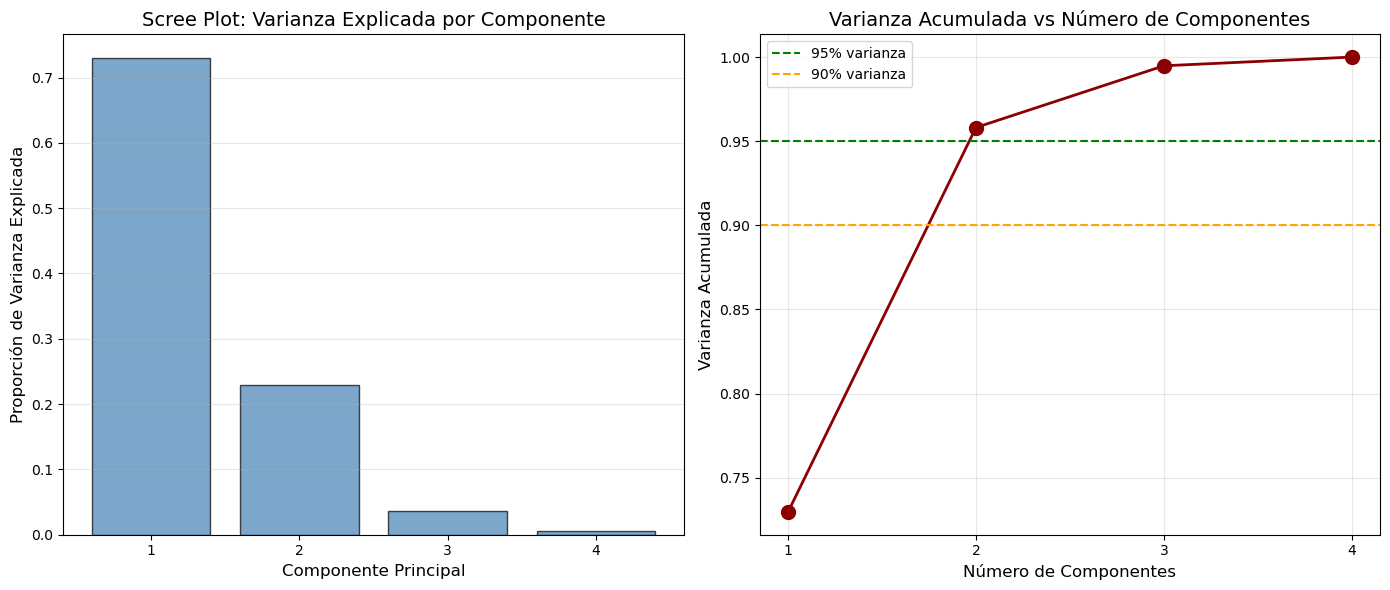

In [16]:
# ----------------------------------------------------------------------------
# 3.E. MODIFICACIONES: VARIANZA EXPLICADA Y SCREE PLOT
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("MODIFICACIONES PCA: Varianza Explicada y Scree Plot")
print("="*80)

# Calcular PCA con todos los componentes
pca_full = PCA()
pca_full.fit(X_iris_scaled)

# Varianza explicada
print("\n--- Varianza Explicada por Componente ---")
for i, var in enumerate(pca_full.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")

print(f"\nVarianza acumulada:")
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
for i, cumvar in enumerate(cumsum_var):
    print(f"PC1-PC{i+1}: {cumvar:.4f} ({cumvar*100:.2f}%)")

# Scree Plot (Gráfica de Codo)
plt.figure(figsize=(14, 6))

# Subplot 1: Varianza explicada por componente
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
        pca_full.explained_variance_ratio_,
        alpha=0.7,
        color='steelblue',
        edgecolor='black')
plt.xlabel('Componente Principal', fontsize=12)
plt.ylabel('Proporción de Varianza Explicada', fontsize=12)
plt.title('Scree Plot: Varianza Explicada por Componente', fontsize=14)
plt.xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
plt.grid(True, alpha=0.3, axis='y')

# Subplot 2: Varianza acumulada
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumsum_var) + 1),
         cumsum_var,
         marker='o',
         linestyle='-',
         color='darkred',
         markersize=10,
         linewidth=2)
plt.axhline(y=0.95, color='green', linestyle='--', label='95% varianza')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% varianza')
plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada', fontsize=12)
plt.title('Varianza Acumulada vs Número de Componentes', fontsize=14)
plt.xticks(range(1, len(cumsum_var) + 1))
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



--- Aplicación de PCA (3 componentes) ---
Forma después de PCA (3D): (150, 3)

Varianza explicada por cada componente:
  PC1: 0.7296 (72.96%)
  PC2: 0.2285 (22.85%)
  PC3: 0.0367 (3.67%)
  Total: 0.9948 (99.48%)


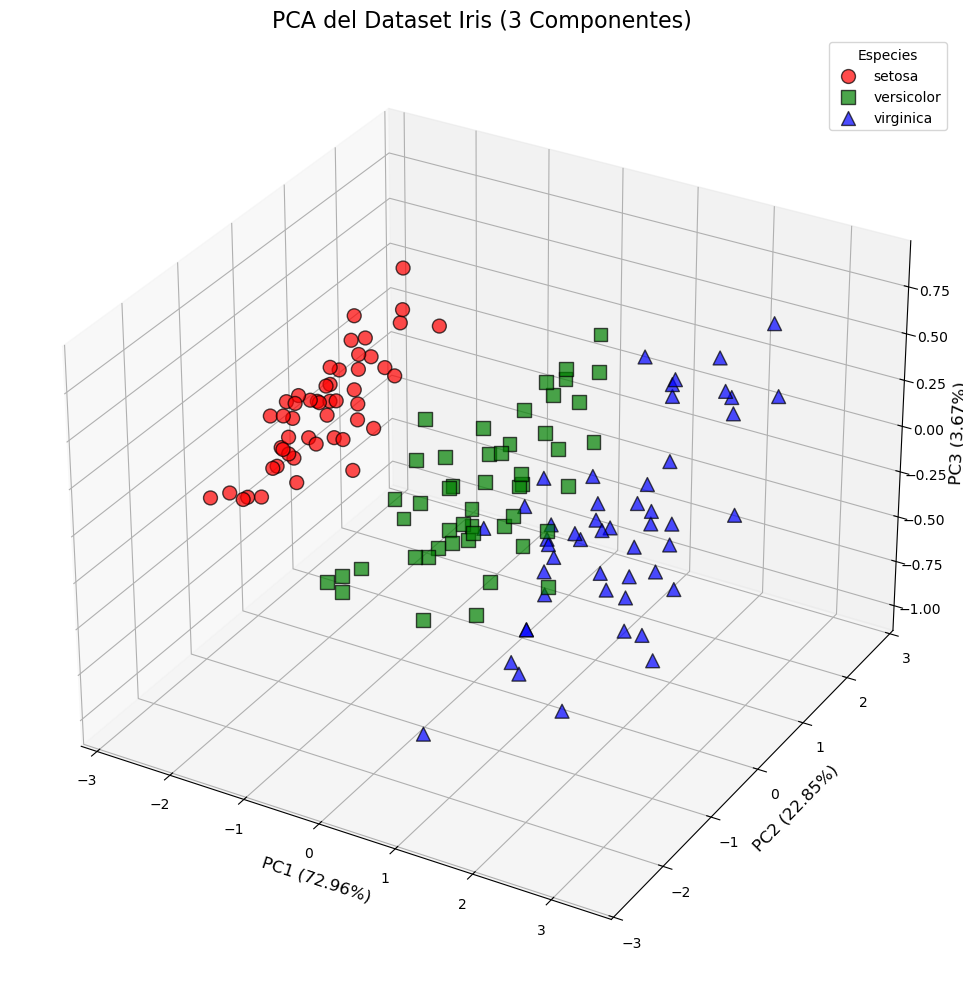

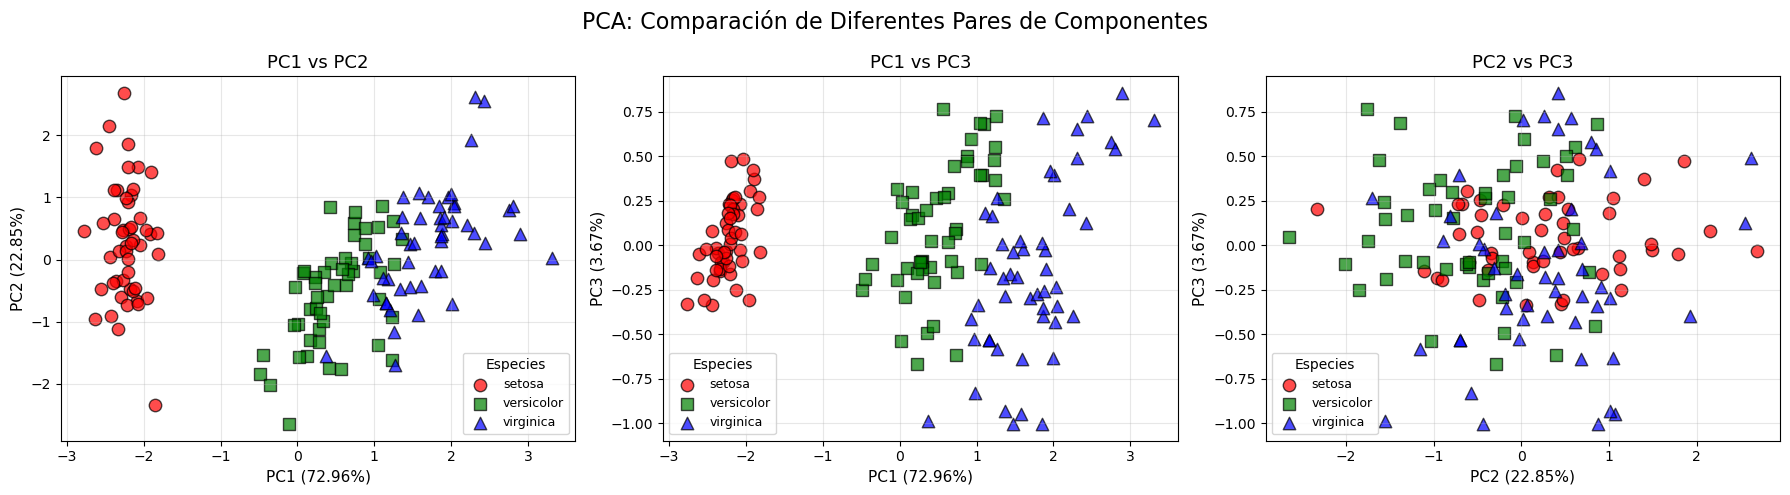

In [17]:
# ----------------------------------------------------------------------------
# 3.F. MODIFICACIONES: PCA CON 3 COMPONENTES
# ----------------------------------------------------------------------------

print("\n--- Aplicación de PCA (3 componentes) ---")

# Aplicar PCA con 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_iris_scaled)

print(f"Forma después de PCA (3D): {X_pca_3d.shape}")
print(f"\nVarianza explicada por cada componente:")
for i, var in enumerate(pca_3d.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"  Total: {pca_3d.explained_variance_ratio_.sum():.4f} ({pca_3d.explained_variance_ratio_.sum()*100:.2f}%)")

# Visualización 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for i, species in enumerate(iris.target_names):
    mask = y_iris == i
    ax.scatter(
        X_pca_3d[mask, 0],
        X_pca_3d[mask, 1],
        X_pca_3d[mask, 2],
        c=colors_iris[i],
        marker=markers[i],
        label=species,
        s=100,
        alpha=0.7,
        edgecolors='black'
    )

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)', fontsize=12)
ax.set_title('PCA del Dataset Iris (3 Componentes)', fontsize=16)
ax.legend(title='Especies')
plt.tight_layout()
plt.show()

# Comparación 2D de diferentes combinaciones de componentes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('PCA: Comparación de Diferentes Pares de Componentes', fontsize=16)

combinations = [(0, 1, 'PC1', 'PC2'), (0, 2, 'PC1', 'PC3'), (1, 2, 'PC2', 'PC3')]

for idx, (pc1, pc2, label1, label2) in enumerate(combinations):
    ax = axes[idx]
    
    for i, species in enumerate(iris.target_names):
        mask = y_iris == i
        ax.scatter(
            X_pca_3d[mask, pc1],
            X_pca_3d[mask, pc2],
            c=colors_iris[i],
            marker=markers[i],
            label=species,
            s=80,
            alpha=0.7,
            edgecolors='black'
        )
    
    var1 = pca_3d.explained_variance_ratio_[pc1] * 100
    var2 = pca_3d.explained_variance_ratio_[pc2] * 100
    
    ax.set_xlabel(f'{label1} ({var1:.2f}%)', fontsize=11)
    ax.set_ylabel(f'{label2} ({var2:.2f}%)', fontsize=11)
    ax.set_title(f'{label1} vs {label2}', fontsize=13)
    ax.legend(title='Especies', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Conclusiones PCA

En el dataset Iris, PCA permitió reducir la dimensionalidad manteniendo la mayor parte de la información en pocas componentes principales. Las primeras dos componentes concentran la mayoría de la varianza total, lo que se comprobó tanto con los valores de varianza explicada como con la gráfica de codo (scree plot), donde se aprecia un punto de inflexión claro a partir de las primeras componentes.

La proyección 2D (PC1 vs PC2) mostró que las clases no son perfectamente separables, pero sí existe una buena separación para al menos una de las especies, mientras que las otras dos se traslapan parcialmente. Al extender el análisis a 3 componentes, se conserva aún más varianza y se obtiene una visualización donde se distingue mejor la estructura de los datos en el espacio reducido.

En conjunto, los resultados confirman que PCA es una herramienta eficaz para:
- Comprender la estructura interna de los datos mediante componentes ortogonales.
- Reducir dimensionalidad sin perder demasiada información.
- Facilitar la visualización y servir como paso de preprocesamiento antes de aplicar otros algoritmos de aprendizaje.


## Conclusiones generales de la actividad

A partir de los experimentos realizados se pueden extraer varias conclusiones sobre el comportamiento y el rol de cada técnica:

- **K-Means** es un algoritmo de clustering particional que funciona bien cuando los clústers son aproximadamente esféricos y de densidad similar. Ofrece resultados interpretables y escalables, pero exige conocer o estimar el número de clústers k y es sensible a la inicialización. En el caso del dataset de dígitos, un valor de k coherente con el número de clases permitió agrupar razonablemente las muestras, aunque se observó que cambios en k y en la inicialización afectan de manera importante las métricas de calidad.

- **DBSCAN** aborda el clustering desde la perspectiva de la densidad. No requiere especificar k y, a cambio, introduce los hiperparámetros `eps` y `min_samples`, que controlan el tamaño de las regiones densas. Cuando estos valores se eligen de forma adecuada, el algoritmo detecta clústers de forma arbitraria y etiqueta claramente el ruido, algo que K-Means no puede hacer. Sin embargo, su sensibilidad a `eps` y `min_samples` hace que el ajuste sea más delicado, especialmente en datasets con densidades muy distintas.

- **PCA** no es un algoritmo de clustering, sino una técnica de reducción de dimensionalidad que transforma las características originales en componentes principales no correlacionadas. En esta actividad, PCA permitió:
  - Entender qué direcciones de variación son más importantes en Iris.
  - Visualizar datos de alta dimensión en 2D y 3D.
  - Servir como posible etapa previa para algoritmos de clustering o clasificación, al concentrar la mayor parte de la varianza en pocas dimensiones.

En conjunto, los resultados muestran que no existe un único método “mejor”, sino que cada algoritmo resuelve un problema distinto y se vuelve más útil en contextos específicos. K-Means es una opción sencilla y rápida para clústers relativamente regulares, DBSCAN es más robusto ante ruido y formas complejas, y PCA complementa a ambos al ofrecer una representación más compacta y visualmente interpretable de los datos.
